In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### First task: plot up a couple of haloes for a comparison plot

Whether this makes it into the paper or not is another issue, but could be a nice issue to explain points in the paper.

I will use the 'typical' example of the Milky Way.

In [2]:
import halo_modified

### Milky Way for reference #######

m_b_mw = [4e9] * u.Msun
delta_m_b_mw = [0] * u.Msun

m_d_mw = [5.3e10] * u.Msun
delta_m_d_mw = [0.5e10] * u.Msun

a_b_mw = [0.6] * u.kpc
delta_a_b_mw = [0] * u.kpc

R_d_mw = [2.15] * u.kpc
delta_R_d_mw = [0.14] * u.kpc

m_hi_mw = None
delta_m_hi_mw = None

mw_halo = halo_modified.TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,
                                  a_b_mw,delta_a_b_mw,R_d_mw,delta_R_d_mw,
                                  m_hi_mw,delta_m_hi_mw,
                                  None,None,None,None,1,0)

m_h = mw_halo.halo_mass()[0].data * u.Msun
m_h_hernquist = mw_halo.halo_mass_hernquist()[0].data * u.Msun
rho0_burkert = mw_halo.burkert_rho0()[0].data * (u.Msun/u.kpc**3)
R_h = mw_halo.halo_scale_length()[0].data * u.kpc

In [3]:
def hernquist_halo(M,a,r):
    return (M/(2*math.pi)) * (a/r) * (1/(r+a)**3)

def burkert_halo(rho0,a,r):
    return rho0 * a**3 / ((r+a)*(r**2+a**2))

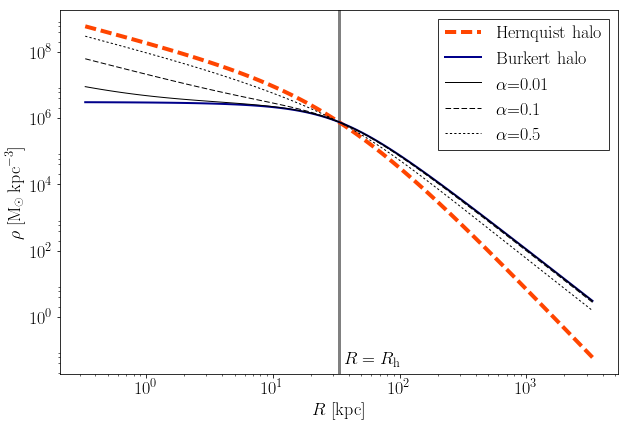

In [4]:
fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

r = np.logspace(-2,2,100) * R_h.value
rho_h = hernquist_halo(m_h_hernquist.value,R_h.value,r)
rho_b = burkert_halo(rho0_burkert.value,R_h.value,r)

plt.sca(ax)
_ = ax.plot(r,rho_h,color='orangered',lw=4,linestyle='dashed',
            label='Hernquist halo')
_ = ax.plot(r,rho_b,color='darkblue',lw=2,
            label='Burkert halo')
_ = plt.axvline(R_h.value,lw=3,color='grey',zorder=-1)


styles = ('solid','dashed','dotted')
alphas = (0.01,0.1,0.5)

for style, alpha in zip(styles,alphas):
    rho = alpha * rho_h + (1-alpha)*rho_b
    _ = ax.plot(r,rho,color='k',linestyle=style,lw=1,
                label=r'$\alpha$={}'.format(alpha))

_ = ax.set_yscale('log')
_ = ax.set_xscale('log')
_ = ax.set_xlabel('$R$ [kpc]')
_ = ax.set_ylabel(r'$\rho$ [$\mathrm{M_\odot \, kpc^{-3}}$]')

_ = ax.legend(fancybox=False,edgecolor='k')

_ = ax.text(0.51,0.01,'$R=R_\mathrm{h}$',
            transform=ax.transAxes,ha='left',va='bottom')

#### Now, for the science part -- we should be able to calculate the required flattening to produce our spiral arm numbers.

In [10]:
masks = Table.read('fits/masks.fits')
morph_data = Table.read('fits/morph_data.fits')
structure_data = Table.read('fits/structure_data.fits')
halo_data = Table.read('fits/sdss_halo_table_matched.fits')
halo_w_gas = Table.read('fits/sdss_w_gas_table_matched.fits')
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [28]:
# Create some masks
sample_ok = np.all([masks['z<0.085 (+HI unbarred spiral)'],
                    structure_data['dBD'] <= 2],axis=0)

r_half = gz2_data['PETROR50_R_KPC'] / 1.5

In [29]:
# Define some conversion factors...

def calculate_alpha(m_observed,m_burkert,m_hernquist):
    return (m_observed - m_burkert) / (m_hernquist - m_burkert)

def m_predicted(m_burkert,m_hernquist,alpha=1):
    return (alpha * m_hernquist) + ((1-alpha) * m_burkert)

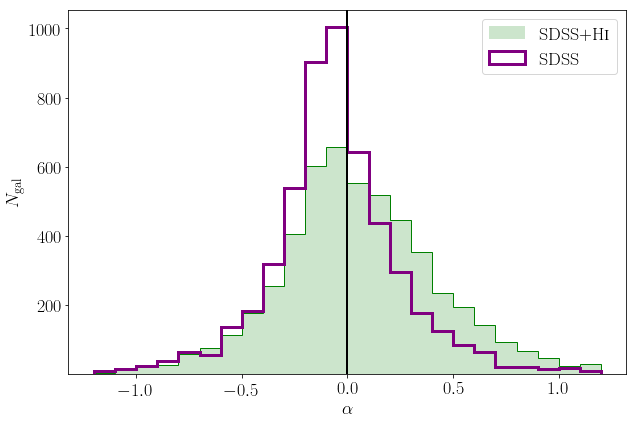

In [30]:
fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

bins = np.linspace(-1.2,1.2,25)

mask = sample_ok.copy()
#mask = secure_sample.copy()

# Gassed
m_observed = morph_data['m_avg']
m_burkert_hi = halo_w_gas['m_burkert_2R_d']
m_hernquist_hi = halo_w_gas['m_hernquist_2R_d']
alphas_hi = calculate_alpha(m_observed,m_burkert_hi,m_hernquist_hi)
_ = ax.hist(alphas_hi[mask],bins,histtype='stepfilled',color='g',alpha=0.2,
            label=r'SDSS+H\textsc{i}')
_ = ax.hist(alphas_hi[mask],bins,histtype='step',color='g',lw=1,
            label='_nolegend_')

# Gasless
m_observed = morph_data['m_avg']
m_burkert = halo_data['m_burkert_2R_d']
m_hernquist = halo_data['m_hernquist_2R_d']
alphas = calculate_alpha(m_observed,m_burkert,m_hernquist)
_ = ax.hist(alphas[mask],bins,histtype='step',color='purple',lw=3,
            label='SDSS')

_ = ax.set_xlabel(r'$\alpha$')
_ = ax.set_ylabel(r'$N_\mathrm{gal}$')
_ = ax.legend()

plt.sca(ax)
_ = plt.axvline(0,color='k',lw=2)

In [31]:
def alpha_printer(alphas):
    ok_alpha = np.all([alphas >= 0, alphas <= 1],axis=0)
    print('{}/{} have 0 < alpha < 1 ({}%)'.format(ok_alpha.sum(),
                                                  len(ok_alpha),
            np.round(ok_alpha.sum()/len(ok_alpha)*100),decimals=1))
    return None

alpha_printer(alphas[mask])
alpha_printer(alphas_hi[mask])

alpha_ok = np.all([alphas >= 0, alphas <= 1],axis=0)
alpha_ok_hi = np.all([alphas >= 0, alphas <= 1],axis=0)

1873/5424 have 0 < alpha < 1 (35.0%)
2644/5424 have 0 < alpha < 1 (49.0%)


#### Correlate alpha w.r.t:

- Stellar mass
- disc scale length

In [120]:
M_bulge = halo_data['M_bulge']
r_bulge = halo_data['R_bulge']

r_disc = halo_data['R_disc_total']
r_disc_hi = halo_w_gas['R_disc_total']
M_disc = halo_data['M_disc_total']
M_disc_hi = halo_w_gas['M_disc_total']

r200 = halo_data['R200']

#from sersic_profiles import BD_half_light_radius
#r_half = BD_half_light_radius(M_bulge,r_bulge,M_disc,r_disc)

#### Now: need to convert the halo mass fractions

Require the following outputs:

- Halo mass (Hernquist)
- $R_{200}$
- $\rho_0$ (Burkert)

In [121]:
def m_halo_m_hernquist(r200,rho0_burkert,M_hernquist,alpha,r0):
    
    r1 = 0.01 * r200
    M_r1_hernquist = M_hernquist * (r1**2/(r1+r0)**2)
    a = 2 * math.pi * rho0_burkert * r0**3
    b = (np.log((r0+r1)/r0) 
       + 0.5 * np.log((r1**2 + r0**2)/r0**2)
       - np.arctan(r1/r0))
    
    M_r1_burkert = a * b
    M_r1_halo = alpha * M_r1_hernquist + (1-alpha) * M_r1_burkert
    return M_r1_halo / M_r1_hernquist

In [122]:
rho0_burkert = halo_data['rho0_burkert']
r0 = halo_data['R_halo']
M_hernquist = halo_data['modified_M_halo']

hmf = m_halo_m_hernquist(r200,rho0_burkert,M_hernquist,
                         alphas,r0)

hmf_hi = m_halo_m_hernquist(r200,rho0_burkert,M_hernquist,
                            alphas_hi,r0)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


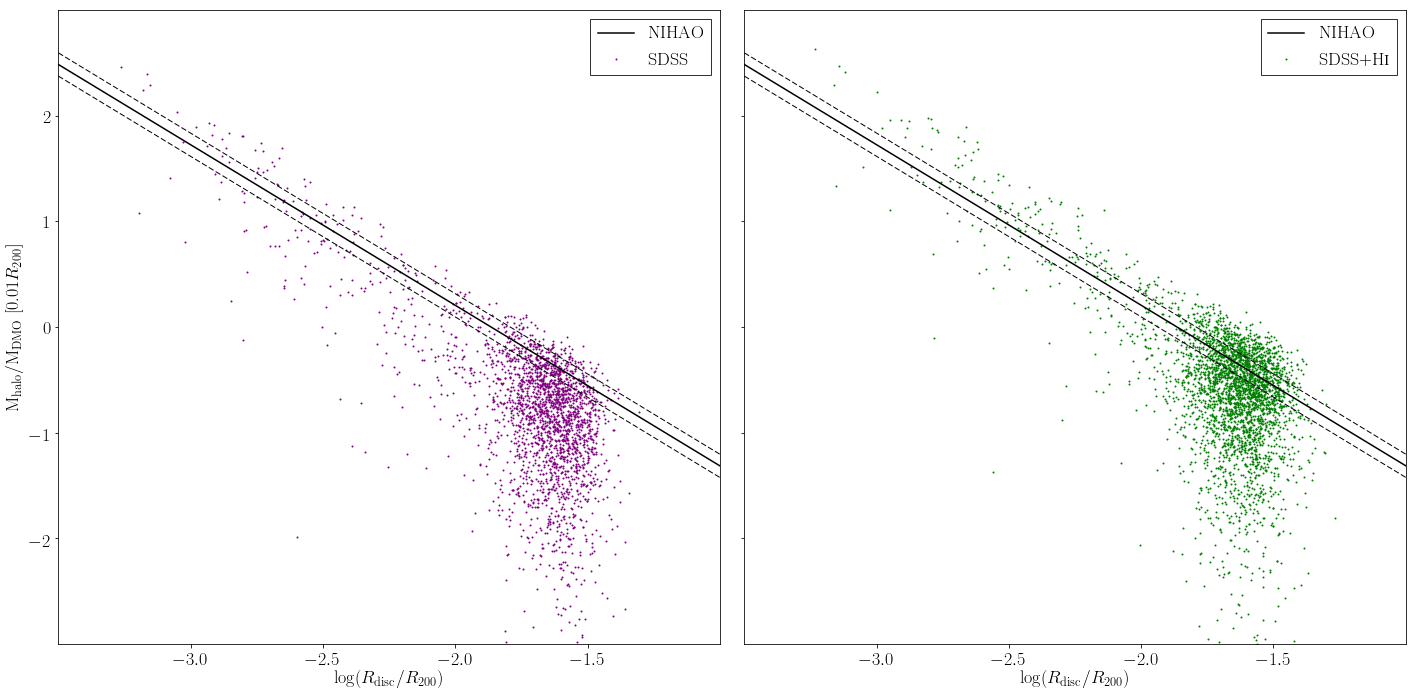

In [126]:
fig, axarr = plt.subplots(1,2,figsize=(20,10),sharex='col',sharey='row')
axarr = axarr.ravel()

def hmf_plotter(ax,x,hmf,xlabel=None,ylabel=False,xlims=(-3,2),
                **kwargs):
    
    loghmf = np.log10(hmf)
    _ = ax.scatter(x,loghmf,**kwargs)
    _ = ax.set_ylim(-3,3)
    if xlabel is not None:
        _ = ax.set_xlabel(xlabel)
    if ylabel is not False:
        _ = ax.set_ylabel(r'$\mathrm{M_{halo}/M_{DMO}}$ [0.01$R_{200}$]')
    if xlims is not None:
        _ = ax.set_xlim(xlims)
    return None

def nihao_line(x):
    median_line = -0.28 - 1.52 * (1.68 + x)
    lower_line = -0.39 - 1.52 * (1.68 + x)
    upper_line = -0.17 - 1.52 * (1.68 + x)
    return median_line, lower_line, upper_line
    
hmf_plotter(axarr[0],np.log10(1.68*r_disc/r200)[mask],hmf[mask],
            '$\log(R_\mathrm{disc}/R_{200})$',True,(-3.5,-1),
            color='purple',s=1,label=r'SDSS')
hmf_plotter(axarr[1],np.log10(1.68*r_disc_hi/r200)[mask],hmf_hi[mask],
            '$\log(R_\mathrm{disc}/R_{200})$',False,(-3.5,-1),
            color='g',s=1,label=r'SDSS+H\textsc{i}')


x_guide = np.linspace(-3.5,-1,100)
y_guide, y_lower, y_upper = nihao_line(x_guide)

for ax in axarr:
    _ = ax.plot(x_guide,y_guide,'k-',label='NIHAO')
    _ = ax.plot(x_guide,y_lower,'k--',lw=1)
    _ = ax.plot(x_guide,y_upper,'k--',lw=1)
    _ = ax.legend(fancybox=False,edgecolor='k')
    
fig.tight_layout()

In [137]:
hmf_expected = 10**(nihao_line(np.log10(1.12*r_disc/r200))[0])
hmf_expected_hi = 10**(nihao_line(np.log10(1.12*r_disc_hi/r200))[0])
#hmf_manual = 10**(nihao_fit(np.log10(r_disc/r200),-0.8))

#### Define a 'new quantity':

$\mathrm{modified \, halo \, mass (MHM) = M_{halo}/M_{DMO}} \, [0.01R_{200}]$

From an observational perspective, we expect things to correlate nicley with MHM: galaxies closer to the NIHAO prediction _should_ have characteristics of modal spiral arms.

* We can also investigate whether the introduction of the NIHAO IX changes introduces/improves any correlations.

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


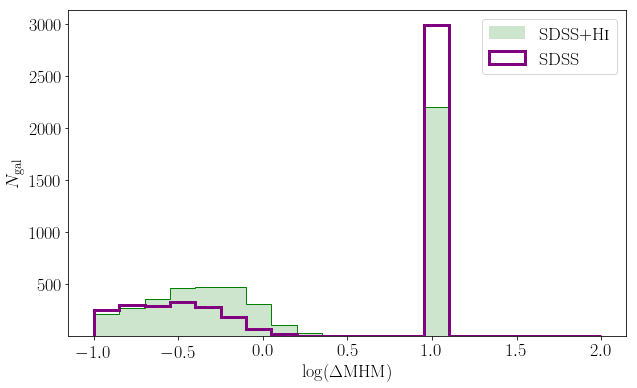

In [140]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)

bins = np.linspace(-1,2,21)

delta_hmf = np.log10(hmf / hmf_expected)
delta_hmf_hi = np.log10(hmf_hi / hmf_expected_hi)

_ = ax.hist(delta_hmf_hi[mask],bins,
            color='g',alpha=0.2,histtype='stepfilled',
            label=r'SDSS+H\textsc{i}')
_ = ax.hist(delta_hmf_hi[mask],bins,
             color='g',lw=1,histtype='step',label='_nolegend_')

_ = ax.hist(delta_hmf[mask],bins,
             color='purple',lw=3,histtype='step',label=r'SDSS')

_ = ax.set_xlabel(r'$\log(\Delta \mathrm{MHM})$')
_ = ax.set_ylabel('$N_\mathrm{gal}$')
_ = ax.legend()

#### How does the NIHAO modification affect the correlation?

- Try this for various offsets: 

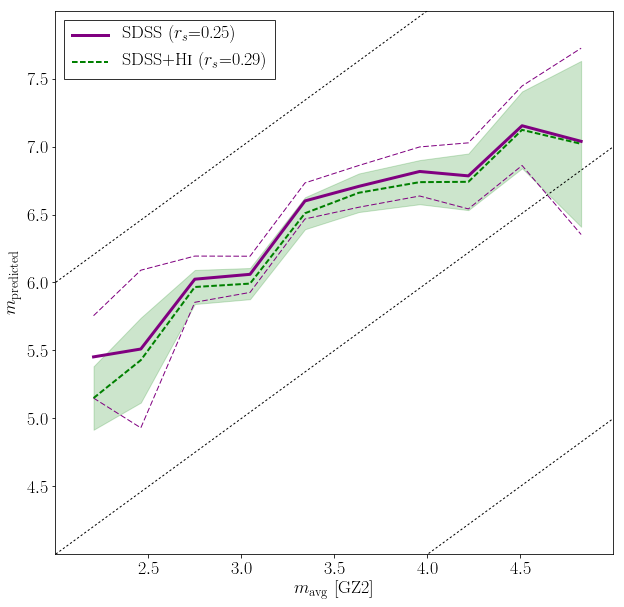

In [129]:
from xy_plots import x_vs_y
from scipy.stats import spearmanr

alpha_mask = np.all([mask,alpha_ok],axis=0)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

alpha_nihao = hmf_expected.copy()
alpha_nihao_hi = hmf_expected_hi.copy()
#alpha_manual = hmf_manual.copy()

m_predicted_nihao = m_predicted(m_burkert,m_hernquist,alpha_nihao)
m_predicted_nihao_hi = m_predicted(m_burkert,m_hernquist,alpha_nihao_hi)

#m_predicted_manual = m_predicted(m_burkert,m_hernquist,
                                 #alpha_manual)

x = morph_data['m_avg'][alpha_mask]
y = m_predicted_nihao[alpha_mask]
r_s, _ = spearmanr(x,y)
label = r'SDSS ($r_s$={})'.format(np.round(r_s,2))
xy = x_vs_y(x,y).continuous_vs_continuous_binned_median()
_ = xy.line_plot(ax,color='purple',lw=3,linestyle='solid',label=label)
_ = xy.error_plot(ax,color='purple',style='lined',
                  lw=1,linestyle='dashed')

y = m_predicted_nihao_hi[alpha_mask]
r_s, _ = spearmanr(x,y)
label_hi = r'SDSS+H\textsc{{i}} ($r_s$={})'.format(np.round(r_s,2))
xy = x_vs_y(x,y).continuous_vs_continuous_binned_median()
_ = xy.line_plot(ax,color='g',lw=2,linestyle='dashed',label=label_hi)
_ = xy.error_plot(ax,style='filled',color='g',alpha=0.2)

_ = ax.legend(fancybox=False,edgecolor='k')
for offset in np.arange(0,10,2):
    _ = ax.plot([1,5],[1+offset,5+offset],color='k',
                lw=1,linestyle='dotted')
    _ = ax.set_xlim(2,5)
    _ = ax.set_ylim(4,8)

_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

#### Now for the f_d vs. m relation for bins of alpha:

In [130]:
from bin_statistics import assign_bins
from scipy.optimize import curve_fit

def fd_function(x,k,c):
    return k / x + c

mask = sample_ok.copy()

ks = []
cs = []

disc_mass_22 = halo_data['M_disc_total_2.2'][mask]
bulge_mass_22 = halo_data['M_bulge_2.2'][mask]
halo_mass_22_hernquist = halo_data['M_halo_2.2_hernquist'][mask]
halo_mass_22_burkert = halo_data['M_halo_2.2_burkert'][mask]

test_alphas = np.linspace(0,1,1000)

for alpha in test_alphas:
    
    m_p_alpha = m_predicted(m_burkert[mask],m_hernquist[mask],
                            alpha)
    
    halo_mass_22 = ((alpha * halo_mass_22_hernquist) 
                  + (1-alpha) * halo_mass_22_burkert)
    
    f_d = disc_mass_22 / (disc_mass_22 + bulge_mass_22 + halo_mass_22)
    
    p, p_cov = curve_fit(fd_function,f_d,m_p_alpha)
    ks.append(p[0])
    cs.append(p[1])
    
ks = np.array(ks)
cs = np.array(cs)

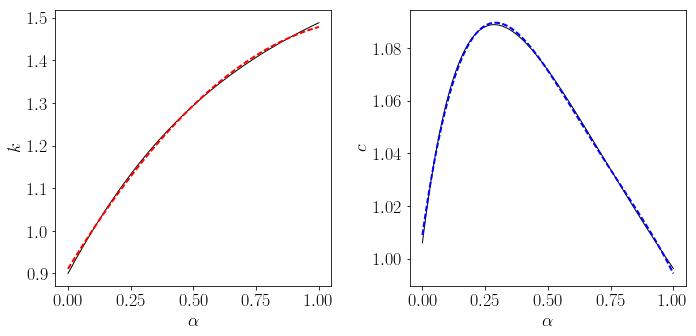

In [131]:
from scipy.optimize import curve_fit

def linear(x,m,c):
    return m*x + c

def quadratic(x,a,b,c):
    return a*x**2 + b*x + c

def cubic(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

def n4(x,a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

x_guide = np.linspace(0,1,1000)

fig, axarr = plt.subplots(1,2,figsize=(10,5))

p_k, _ = curve_fit(quadratic,test_alphas,ks,p0=(1,1,1))
_ = axarr[0].plot(test_alphas,ks,color='k',lw=1)
_ = axarr[0].plot(x_guide,quadratic(x_guide,*p_k),
                  color='r',lw=2,linestyle='dashed')

p_c, _ = curve_fit(n4,test_alphas,cs)
_ = axarr[1].plot(test_alphas,cs,color='k',lw=1)
_ = axarr[1].plot(x_guide,n4(x_guide,*p_c),
                  color='b',lw=2,linestyle='dashed')

_ = axarr[0].set_xlabel(r'$\alpha$')
_ = axarr[0].set_ylabel('$k$')
_ = axarr[1].set_xlabel(r'$\alpha$')
_ = axarr[1].set_ylabel('$c$')

_ = fig.tight_layout()

In [132]:
def correct_fd(halo_table,morph_table,alphas,k_func,c_func,p_k,p_c):
    
    def fd_function(x,k,c):
        return k / x + c
    
    def inverse_fd_function(y,k,c):
        return k /(y-c)
    
    k = k_func(alphas,*p_k)
    c = c_func(alphas,*p_c)
    
    disc_mass_22 = halo_table['M_disc_total_2.2']
    bulge_mass_22 = halo_table['M_bulge_2.2']
    halo_mass_22_hernquist = halo_table['M_halo_2.2_hernquist']
    halo_mass_22_burkert = halo_table['M_halo_2.2_burkert']
    m_observed = morph_table['m_avg']
    halo_mass_22 = ((alpha * halo_mass_22_hernquist) 
                  + ((1-alpha) * halo_mass_22_burkert))
    
    fd_observed = (disc_mass_22 
                  / (disc_mass_22 + bulge_mass_22 + halo_mass_22))
    
    fd_required = inverse_fd_function(m_observed,k,c)
    
    return fd_observed, fd_required


def correct_m(halo_table,mass_correction,alphas,k_func,c_func,p_k,p_c):
    
    def fd_function(x,k,c):
        return k / x + c
    
    def inverse_fd_function(y,k,c):
        return k /(y-c)
    
    k = k_func(alphas,*p_k)
    c = c_func(alphas,*p_c)
    
    disc_mass_22 = halo_table['M_disc_total_2.2'] + mass_correction
    bulge_mass_22 = halo_table['M_bulge_2.2'] - mass_correction
    halo_mass_22_hernquist = halo_table['M_halo_2.2_hernquist']
    halo_mass_22_burkert = halo_table['M_halo_2.2_burkert']
    halo_mass_22 = ((alpha * halo_mass_22_hernquist) 
                  + ((1-alpha) * halo_mass_22_burkert))
    
    fd = (disc_mass_22 
        / (disc_mass_22 + bulge_mass_22 + halo_mass_22))
    
    m_predicted = fd_function(fd,k,c)
    return m_predicted
    

In [133]:
mask = sample_ok.copy()

fd_observed, fd_required = correct_fd(halo_data[mask],morph_data[mask],
                                      alpha_nihao[mask],
                                      quadratic,n4,p_k,p_c)

mb_correction = ((fd_required-fd_observed) 
                * halo_data[mask]['M_disc_total_2.2'])

mb_22_observed = halo_data['M_bulge_2.2'][mask]
mb_22_required = mb_22_observed - mb_correction

3266/5424 have reasonable bulges


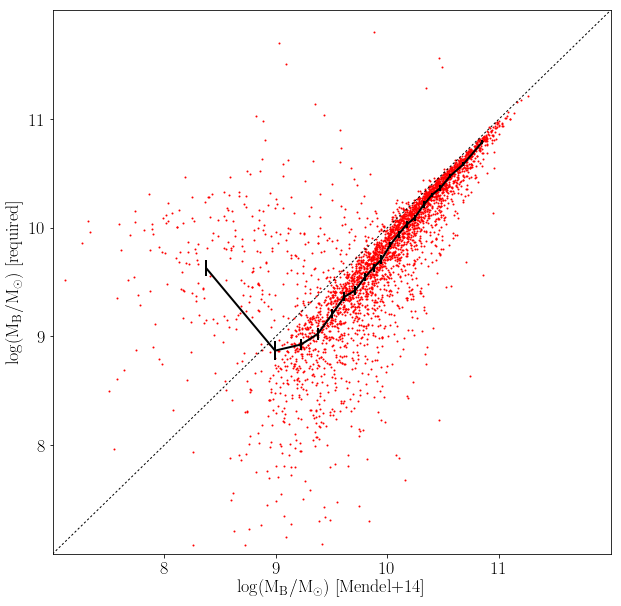

In [134]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

ok_mb = np.all([mb_22_required > 10**7,mb_22_required <= 10**13,
                mb_22_observed > 10**7,mb_22_observed <= 10**13],axis=0)

print('{}/{} have reasonable bulges'.format(ok_mb.sum(),mask.sum()))

x = np.log10(mb_22_observed[ok_mb])
y = np.log10(mb_22_required[ok_mb])
xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(equal_N=True,bins=20)
xy.error_plot(ax,style='errorbar',color='k',lw=2)

_ = ax.scatter(x,y,s=1,color='r')
_ = ax.set_xlabel('$\log(\mathrm{M_B/M_\odot})$ [Mendel+14]')
_ = ax.set_ylabel('$\log(\mathrm{M_B/M_\odot})$ [required]')

_ = ax.set_xlim(7,12)
_ = ax.set_ylim(7,12)
_ = ax.plot([7,12],[7,12],color='k',lw=1,linestyle='dotted')

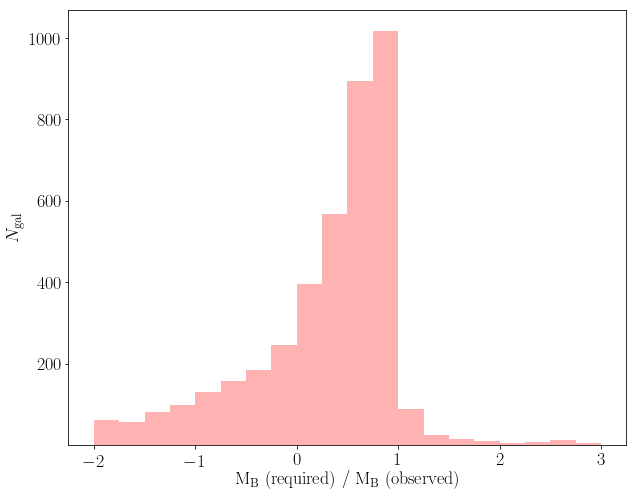

In [135]:
bins = np.linspace(-2,3,21)
required_fraction = mb_22_required/mb_22_observed
plt.hist(required_fraction,bins,color='r',histtype='stepfilled',
         alpha=0.3)

_ = plt.xlabel('$\mathrm{M_B}$ (required) / $\mathrm{M_B}$ (observed)')
_ = plt.ylabel('$N_\mathrm{gal}$')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


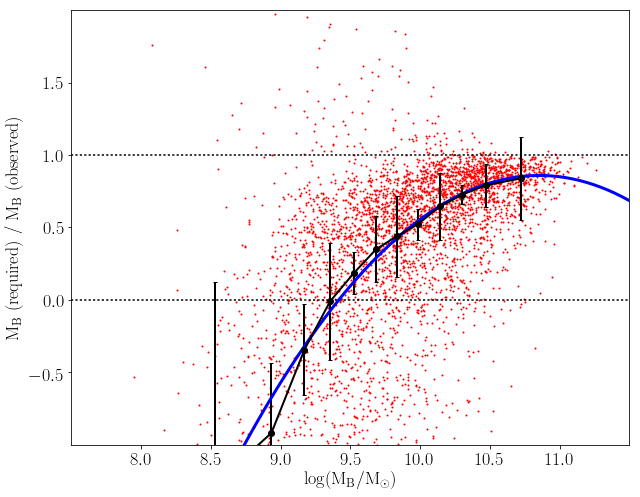

In [136]:
fig = plt.figure()
ax = plt.subplot(111)
plt.sca(ax)

x = np.log10(mb_22_observed)
y = required_fraction
xy_ok = np.all([y >= -100, y <= 100, np.isfinite(x)],axis=0)

xy = x_vs_y(x[xy_ok],y[xy_ok]).continuous_vs_continuous_binned_median(
    equal_N=True,bins=12)
xy.scatter(ax,color='r',s=1)
xy.error_plot(ax,color='k',lw=2,style='errorbar',marker='o',capsize=2)

_ = plt.axhline(0,linestyle='dotted',color='k')
_ = plt.axhline(1,linestyle='dotted',color='k')

p_corr, pcov = curve_fit(linear,x[xy_ok],y[xy_ok])
x_guide = np.linspace(6,12,100)
y_guide = linear(x_guide,*p_corr)

_ = ax.set_xlim(7.5,11.5)
_ = ax.set_ylim(-1,2)
_ = ax.set_xlabel('$\log(\mathrm{M_B/M_\odot})$')
_ = ax.set_ylabel('$\mathrm{M_B}$ (required) / $\mathrm{M_B}$ (observed)')

# Fit to the data?
x_binned = xy.x_table['mean']
y_binned = xy.y_table['mean']

p_corr, p_cov = curve_fit(quadratic,x_binned,y_binned)
x_guide = np.linspace(7,12,100)
y_guide = quadratic(x_guide,*p_corr)
_ = plt.plot(x_guide,y_guide,color='b',lw=3)

#### New task: fit the S4G...

In [110]:
s4g = Table.read('fits/s4g_halo_table_matched.fits')
s4g_morph = Table.read('s4g_fits/buta_matched.fits')
s4g_structure = Table.read('s4g_fits/bulge_disc_matched.fits')

in_s4g = s4g['unbarred_sample']

In [111]:
s4g_R_ratio = np.log10(1.68*s4g['R_disc_total']/s4g['R200'])
s4g_alpha_nihao = 10**(nihao_line(s4g_R_ratio)[0])

In [112]:
m_hernquist_s4g = s4g['m_hernquist_2R_d']
m_burkert_s4g = s4g['m_burkert_2R_d']

s4g_m_mod = m_predicted(m_burkert_s4g,m_hernquist_s4g,s4g_alpha_nihao)

     mean      mean-1sigma   mean+1sigma 
------------- ------------- -------------
4.55581655638 4.09656905615  5.0150640566
5.26350771437 5.01066929917 5.51634612957
9.10732981548 7.92857432319 10.2860853078


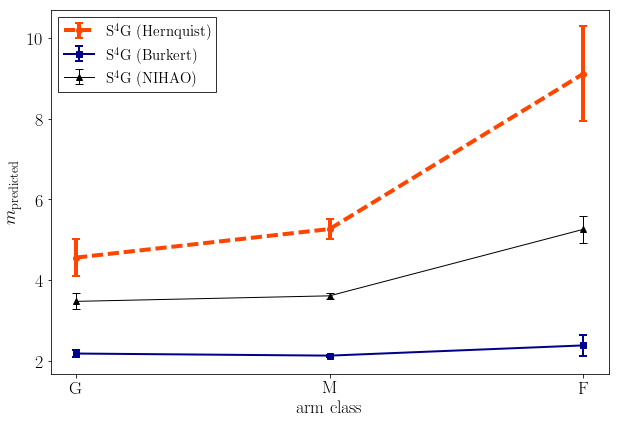

In [113]:
fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

arm_class = s4g_morph['AC'][in_s4g]
ac_number = np.zeros(len(arm_class))
ac_number[arm_class == b'G'] = 1
ac_number[arm_class == b'M'] = 2
ac_number[arm_class == b'F'] = 3

x = ac_number.copy()
y_h = s4g['m_hernquist_2R_d'][in_s4g]
y_b = s4g['m_burkert_2R_d'][in_s4g]
y_nihao = s4g_m_mod[in_s4g]

xy_h = x_vs_y(x,y_h).discrete_vs_continuous_binned_median()
xy_b = x_vs_y(x,y_b).discrete_vs_continuous_binned_median()
xy_nihao = x_vs_y(x,y_nihao).discrete_vs_continuous_binned_median()

_ = xy_h.error_plot(ax,lw=4,style='errorbar',
                    color='orangered',label=r'S$^4$G (Hernquist)',
                    linestyle='dashed',capsize=4,capthick=2,marker='o')
_ = xy_b.error_plot(ax,lw=2,style='errorbar',
                    color='darkblue',label=r'S$^4$G (Burkert)',
                    capsize=4,capthick=2,marker='s')

_ = xy_nihao.error_plot(ax,lw=1,style='errorbar',
                        color='k',label=r'S$^4$G (NIHAO)',
                        capsize=4,capthick=1,marker='^')

_ = ax.set_xlabel('arm class')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')
_ = ax.set_xticks([1,2,3])
_ = ax.set_xticklabels(['G','M','F'])
_ = ax.legend(fontsize=15,fancybox=False,edgecolor='k')

#fig.savefig('figures/m_vs_m_s4g.pdf')
print(xy_h.y_table)